In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import numpy as np
from utilities import get_sample_images, plot_images

# Computer Vision 

We shall classify between different cassava diseases by analysing their leaf images

In [2]:
leaf_images = 'pdata/'
train_dir = os.path.join(leaf_images, 'train')
test_dir = os.path.join(leaf_images, 'test')
validation_dir = os.path.join(leaf_images, 'validation')
classes = [cls for cls in os.listdir(train_dir) if not cls.startswith('.')]
print (classes)

['cgm', 'cmd', 'healthy', 'cbb', 'cbsd']


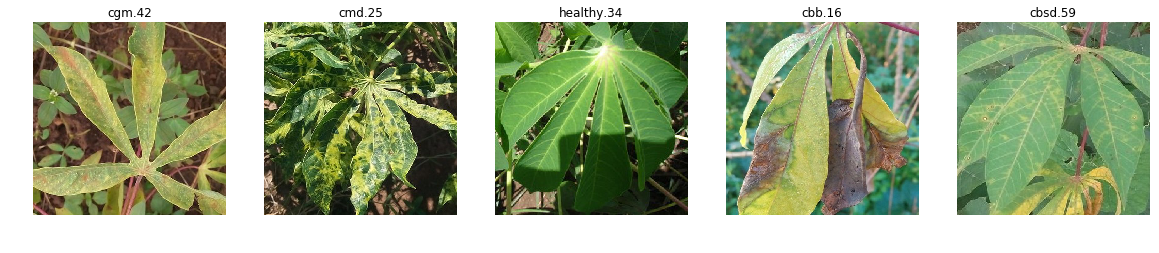

In [3]:
img_ids = np.random.randint(0, 36, size=len(classes))
simgs = get_sample_images(classes, img_ids, train_dir)
plot_images(len(classes), simgs)

## Visual recognition

The goal of computer vision is visual recognition from images and/or videos. Videos can be thought of as a sequence of images (or frames). The most basic, perhaps most common task in visual recognition is image classification. Given an image can we categorize it correctly. For example the disease diagnosis problem we want to tackle in this notebook; given a leaf image can we correctly predict which class of disease the image represents.

Images are particularly important in the African context as a unique data type that transcends the many languages spoken by different people in Africa. For example an image diagnosis application on a mobile phone is easily usable by every farmer who has a smartphone because there is hardly any text she/he is required to read. They point the phone at a plant, take an image and get a big green tick for OK or a big red "X" for sick plant. Other more literate farmers can be trained to read the actual disease and how confident the predictive model is.

## Modeling our disease predictor

The goal is to build some type of model that can take an image and predict disease. As you have probably learnt in the machine learning module, the process of building a good predictor involves selecting a model class and fitting it to some training dataset, a process surprisingly called `training`. Our trained model is then our predictor that we can use to predict in our case diseases from other cassava plants not used in the training. 

![How the modeling works](./modeling.png)

## Feature Extraction

Traditionally the way computer vision problems were tackled was to figure out ways of extracting features from the images that related to the problem. For example by looking at the images of the different classes one can think of extracting perhaps color features, perhaps try different color spaces (RGB, HSV, etc) and see which works best. One perhaps could extract features related to the `shape` of the leaves. Some diseases seem to deform the leaves more than others. Or perhaps one may look for points of interest on the leaves for example the brown spots using SIFT of SURF features. OpenCV or SciKit-Image are good toolboxes for extracting these types of features. 

However handcrafting features, a process called feature engineering can sometimes be very complex and hard to generalize from one problem to the next. Sometimes this is the way that works however, particularly when small relatively standard datasets or a fairly scoped problem exists. The current trend however is to use Deep Neural Networks (DNN). Particularly for computer vision, a particular kind of DNN is used called a Convolutional Neural Network (CNN). 

## Convolutional Neural Networks (CNNs)

CNNs provide a relatively automated way of extracting different features from the image, also called image representations. What is particularly nice about CNNs is that they are able to extract different levels of representations of the image from basic edges to more detailed feature representations for example in our case from the shape of the leaves to specific brown patches on the top parts of the leaf for some disease classes.

The next lecture and several tutorials online go deeper into CNNs but suffice to say they are the latest state-of-the-art in computer vision and have been shown to perform quite well for many visual recognition problems. We will use the Keras toolbox for this tutorial. This tutorial abstracts from some of the Keras tutorials, so you can go to the Keras site and look at the examples for more clarification. Keras also now comes bundled with tensorflow.

## Data preprocessing

To work with `Keras` and generally most CV toolboxes, the image data should be formatted into appropriately pre-processed floating point tensors (you can think of tensors as just numerical numpy arrays) before being fed into our 
network. For our image data we will follow the following basic steps to get the data into a usable format:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image 
processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to 
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we 
will use here.

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [6]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(300, 300), #Resize images to uniform size
        batch_size=5,
        class_mode='categorical') # Since we are classifying between 5 classes

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(300, 300),
        batch_size=5,
        class_mode='categorical')

Found 268 images belonging to 5 classes.
Found 163 images belonging to 5 classes.


Let's take a look at the output of one of these generators: it yields batches of 300x300 RGB images (shape `(20, 300, 300, 3)`) and binary 
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches 
indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop 
at some point.

In [7]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (5, 300, 300, 3)
labels batch shape: (5, 5)


## Building the convolutional model

We will build a simple model here. You goal will be to build and try different model architectures to improve the performace on this dataset. Our convnet will be a stack of alternated Conv2D (with relu activation) and MaxPooling2D layers.

The deeper our convolutional base the smaller the size of the feature maps, so that they aren't overly large when we reach the Flatten layer. Here, since we start from inputs of size 300x300 (a somewhat arbitrary choice), we end up with feature maps of size 16x16 right before the Flatten layer.

Note that the depth of the feature maps is progressively increasing in the network (from 64 to 512), while the size of the feature maps is decreasing (from 298x298 to 7x7). This is a pattern that you will see in almost all convnets.
Since we are attacking a categorical classification problem, we are ending the network with a Dense layer of size 5 and a  softmax activation. This unit will encode the probability that the network is looking at any one of the 5 categories of disease.

In [8]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(300, 300, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 256)       295168    
__________

Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators 
like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. 
Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before 
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the 
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. 

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is 
allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then 
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, 
which tells the process how many batches to draw from the validation generator for evaluation.

In [9]:
from tensorflow.keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=1e-2), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/10
100/100 [==============================] - 126s 1s/step - loss: 12.1696 - acc: 0.2360 - val_loss: 12.1536 - val_acc: 0.2460
Epoch 2/10
100/100 [==============================] - 139s 1s/step - loss: 12.1637 - acc: 0.2453 - val_loss: 11.9586 - val_acc: 0.2581
Epoch 3/10
100/100 [==============================] - 129s 1s/step - loss: 12.4862 - acc: 0.2253 - val_loss: 12.0236 - val_acc: 0.2540
Epoch 4/10
100/100 [==============================] - 132s 1s/step - loss: 11.8843 - acc: 0.2627 - val_loss: 12.4785 - val_acc: 0.2258
Epoch 5/10
100/100 [==============================] - 130s 1s/step - loss: 12.4753 - acc: 0.2260 - val_loss: 12.0886 - val_acc: 0.2500
Epoch 6/10
100/100 [==============================] - 124s 1s/step - loss: 11.9922 - acc: 0.2560 - val_loss: 11.6986 - val_acc: 0.2742
Epoch 7/10
100/100 [==============================] - 115s 1s/step - loss: 12.2391 - acc: 0.2407 - val_loss: 11.8286 - val_acc: 0.2661
Epoch 8/10
100/100 [==============================] - 1

## Ploting results

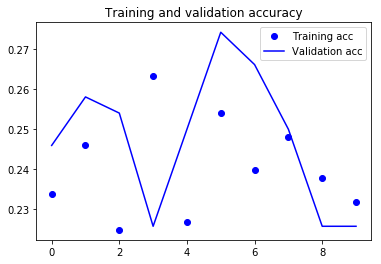

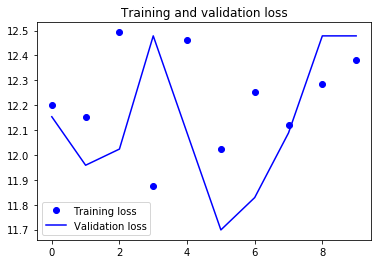

In [11]:
# Get training statistics    
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Plot
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Improving the accuracy with data augmentation

If we tune our parameters further (your homework) eventually the network will start to overfit to the data. Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. 
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data 
augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number 
of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same 
picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator` 
instance. Let's get started with an example:

In [12]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures 
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal 
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

Using TensorFlow backend.


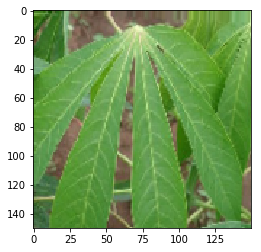

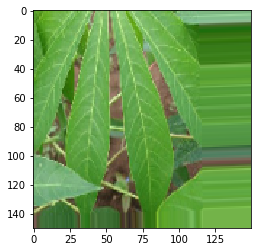

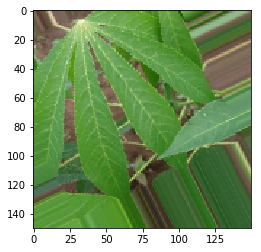

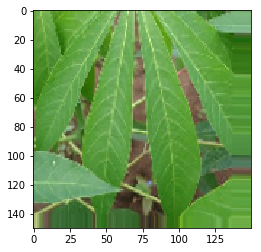

In [13]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

healthy_class = os.path.join(train_dir, 'healthy')
fnames = [os.path.join(healthy_class, fname) for fname in os.listdir(healthy_class)]

# We pick one image to "augment"
img_path = fnames[7]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, 
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight 
overfitting, we will also add some Dropout layers to our model.

In [14]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(300, 300, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

Lets re-train our network with data augmentation

In [15]:
train_datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(300, 300), #Resize images to uniform size
        batch_size=5,
        class_mode='categorical') # Since we are classifying between 5 classes

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(300, 300),
        batch_size=5,
        class_mode='categorical')

Found 268 images belonging to 5 classes.
Found 163 images belonging to 5 classes.


In [16]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/10
100/100 [==============================] - 72s 720ms/step - loss: 12.2948 - acc: 0.2320 - val_loss: 1.7703 - val_acc: 0.1935
Epoch 2/10
100/100 [==============================] - 74s 742ms/step - loss: 13.1206 - acc: 0.1807 - val_loss: 1.8086 - val_acc: 0.1411
Epoch 3/10
100/100 [==============================] - 72s 719ms/step - loss: 12.9595 - acc: 0.1867 - val_loss: 1.6106 - val_acc: 0.2540
Epoch 4/10
100/100 [==============================] - 75s 746ms/step - loss: 12.5752 - acc: 0.2120 - val_loss: 1.6985 - val_acc: 0.2661
Epoch 5/10
100/100 [==============================] - 77s 774ms/step - loss: 12.0121 - acc: 0.2540 - val_loss: 1.9326 - val_acc: 0.2177
Epoch 6/10
100/100 [==============================] - 77s 773ms/step - loss: 12.3894 - acc: 0.2313 - val_loss: 1.9118 - val_acc: 0.2298
Epoch 7/10
100/100 [==============================] - 80s 797ms/step - loss: 12.1235 - acc: 0.2427 - val_loss: 1.6832 - val_acc: 0.2379
Epoch 8/10
100/100 [============================

## Plot new results

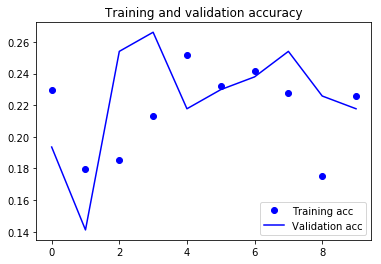

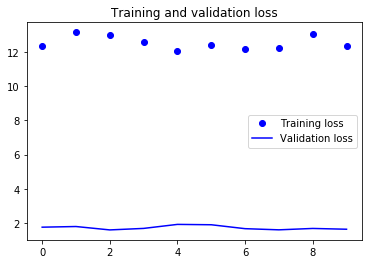

In [17]:
# Get training statistics    
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Plot
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
Not much improvement u

# Students todo:

1. Can you play with the default network (without augumentation) by tuning the different hyperparameters and try and improve the accuracy. One idea is to change the network make the convolutional base deeper, or make the network top (set of dense layers) deeper and see the effect. You can also play with the number of epochs or learning rate. Ensure you keep an eye on the plots so you don't overfit your data

2. Do the same with the data augmentation - by tuning the augmentation parameters can you improve the accuracy of the model? What about model layers, learning rate, etc. 

3. This is a hard problem as shown by the results. Its particularly hard because the dataset is small and CNNs work best with large datasets. So improving the hyperparameters will probably take the accuracy to its 40 - 50s so you should try and aim at that. To make it go higher you will require more data. One way of leveraging more data is to use transfer learning. You can use trained components of other models as a base to build your network or extract features that you use to train your network. Try this out - in our trials the accuracy has risen to about 80%. That should be your target.